### AutoML Model-Building
- Objectives: 
    - This notebook builds an autoML pipeline to predict Indian rice yields

In [15]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import pycaret
from pycaret.regression import *

In [16]:
# Read yield and NDVI/weather data 
processed_weather_yield_df = pd.read_excel('C:\\Users\\djava\\OneDrive\\Documents\\Oxford\\Projects\\india_rice_early_warning\\4_data\\PROCESSED_DATA\\ANALYSIS_READY\\india_yield_weather_ndvi.xlsx')

In [17]:
# filter out data that is 2021 using query
processed_weather_yield_df = processed_weather_yield_df.query('year != 2021')

In [18]:
# Sort data by year ascending for train test split
processed_weather_yield_df = processed_weather_yield_df.sort_values(by='year', ascending=True).copy()

In [19]:
# Drop District, State, Season, Area_ha, Production_t
processed_weather_yield_df.drop(['District', 'State', 'Season', 'Area_ha', 'Production_t'], axis=1, inplace=True)

In [20]:
processed_weather_yield_df

,GID_2,year,Yield_t_ha,Temperature May,Temperature June,Temperature July,Temperature August,Temperature September,Temperature October,Temperature November,...,Precipitation September,Precipitation October,Precipitation November,NDVI May,NDVI June,NDVI July,NDVI August,NDVI September,NDVI October,NDVI November
0,IND.11.12_1,2001,2.250000,33.147400,30.777649,27.703522,27.983978,29.930847,28.725311,24.314117,...,0.000360,0.001253,0.000000,0.353912,0.326378,0.405922,0.609368,0.561315,0.473015,0.401144
3050,IND.3.7_1,2001,0.974964,22.159607,23.933298,24.242014,24.394928,23.320566,20.645721,16.586721,...,0.008354,0.006311,0.000820,0.594013,0.611878,0.670610,0.661715,0.682415,0.640776,0.640321
480,IND.12.7_1,2001,1.515335,33.160076,31.343637,30.122528,30.406616,30.639963,26.643646,20.007273,...,0.000710,0.000239,0.000037,0.166207,0.226323,0.457899,0.449664,0.371510,0.276104,0.234665
3088,IND.30.3_1,2001,1.429167,19.127869,20.736664,21.168213,20.922546,19.737671,17.179871,13.860077,...,0.010831,0.009618,0.008813,0.611862,0.706626,0.788891,0.808338,0.822498,0.794624,0.718623
3108,IND.33.1_1,2001,1.992542,26.435478,26.664841,27.216789,28.038857,27.176018,26.070229,22.969452,...,0.006700,0.008833,0.000968,0.672989,0.710111,0.827761,0.806971,0.855425,0.842053,0.816963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,IND.20.27_1,2020,1.933797,29.667353,27.186295,26.548853,25.737604,26.552555,26.776913,25.906199,...,0.015428,0.007264,0.000078,0.407388,0.511693,0.483261,0.818790,0.829861,0.776244,0.655734
2849,IND.3.12_1,2020,1.998679,21.046295,23.058945,23.703384,25.250788,23.886190,22.872162,17.249090,...,0.017375,0.006538,0.001878,0.727812,0.788743,0.828017,0.847567,0.850859,0.844262,0.809586
99,IND.11.23_1,2020,1.758799,34.856220,30.727428,29.758001,27.661108,29.332539,28.841206,24.378687,...,0.003027,0.000548,0.000008,0.351054,0.422587,0.575896,0.708334,0.716762,0.649666,0.563575
1259,IND.2.4_1,2020,3.985336,33.564568,31.528044,29.256304,28.653496,28.609760,28.094255,26.132399,...,0.012476,0.007602,0.004340,0.324449,0.336075,0.484333,0.538435,0.616640,0.689880,0.667639


In [21]:
# Split data into train and test set
train = processed_weather_yield_df.query('year < 2019')
test  = processed_weather_yield_df.query('year >= 2019')

# Print shape of train and test set
print('Data for Modeling: ' + str(train.shape))
print('Unseen Data For Predictions: ' + str(test.shape))

Data for Modeling: (4606, 24)
Unseen Data For Predictions: (502, 24)


In [28]:
# import pycaret regression and initialize setup
s = setup(data = train,
          test_data=test,
        #   fold_strategy = 'timeseries',
          target = 'Yield_t_ha',
          data_split_shuffle = False,
          # group_features = ['GID_2'],
          session_id = 123,
        #   transformation=True,
        #   normalize=True,
          ignore_features = ['year', 'GID_2'],
        #   log_experiment=True,
        #   experiment_name='no_year_gid2'
          )

,Description,Value
0,Session id,123
1,Target,Yield_t_ha
2,Target type,Regression
3,Original data shape,"(5108, 24)"
4,Transformed data shape,"(5108, 22)"
5,Transformed train set shape,"(4606, 22)"
6,Transformed test set shape,"(502, 22)"
7,Ignore features,2
8,Numeric features,21
9,Rows with missing values,5.8%


In [25]:
# Compare models
best = compare_models(exclude="et", cross_validation=False, sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3079,0.1672,0.4089,0.8051,0.1288,0.1597,1.3000
catboost,CatBoost Regressor,0.2970,0.1548,0.3934,0.8195,0.1246,0.1656,2.5000
xgboost,Extreme Gradient Boosting,0.3071,0.1653,0.4066,0.8072,0.1305,0.1733,0.2300
lightgbm,Light Gradient Boosting Machine,0.3077,0.1690,0.4111,0.8029,0.1320,0.1804,0.1300
gbr,Gradient Boosting Regressor,0.3102,0.1674,0.4091,0.8048,0.1345,0.1919,3.5600
dt,Decision Tree Regressor,0.4098,0.3309,0.5752,0.6141,0.1841,0.2006,0.0900
br,Bayesian Ridge,0.3335,0.2036,0.4513,0.7625,0.1500,0.2239,0.0300
ridge,Ridge Regression,0.3331,0.2031,0.4507,0.7631,0.1499,0.2240,0.0400
lr,Linear Regression,0.3351,0.2067,0.4546,0.7590,0.1515,0.2263,0.0400
lar,Least Angle Regression,0.4233,0.2983,0.5462,0.6521,0.1695,0.2448,0.0400


In [12]:
get_logs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,params.Transformation,params.Transformed data shape,params.Transformed train set shape,params.Numeric imputation,...,params.Imputation type,tags.mlflow.user,tags.Source,tags.Run Time,tags.USI,tags.mlflow.source.name,tags.URI,tags.mlflow.source.type,tags.Run ID,tags.mlflow.runName
0,41c72e5c261a4bf1b5df45ed5a4f5211,1,RUNNING,file:///C:/Users/djava/OneDrive/Documents/Oxfo...,2023-12-14 09:37:47.811000+00:00,None,True,"(5108, 22)","(4606, 22)",mean,...,simple,djava,setup,3.04,6dad,c:\Users\djava\miniconda3\envs\pycaret_rice_v2...,d979d68f,LOCAL,41c72e5c261a4bf1b5df45ed5a4f5211,Session Initialized 6dad


In [11]:
# #PLot residuas of top 3 models for each of hte models in the list and plot side by side in 3 columns
# for model in top3:
#     plot_model(model, plot = 'residuals')

In [113]:
# # plot feature importance
# plot_model(best, plot = 'feature')

In [12]:
# #PLot residuas of top 3 models for each of hte models in the list and plot side by side in 3 columns
# for model in top3:
#     plot_model(model, plot = 'error')

In [13]:
# # predict on test set
# holdout_pred = predict_model(best)

In [14]:
# # show predictions df
# holdout_pred.tail(50)

In [29]:
light_gbm_model = create_model('lightgbm', cross_validation=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,0.4845,0.3884,0.6232,0.5471,0.1952,0.2640


In [10]:
# check_fairness(best, sensitive_features = ['GID_2'])

In [19]:
# # interpret summary model
# interpret_model(best, plot = 'summary')

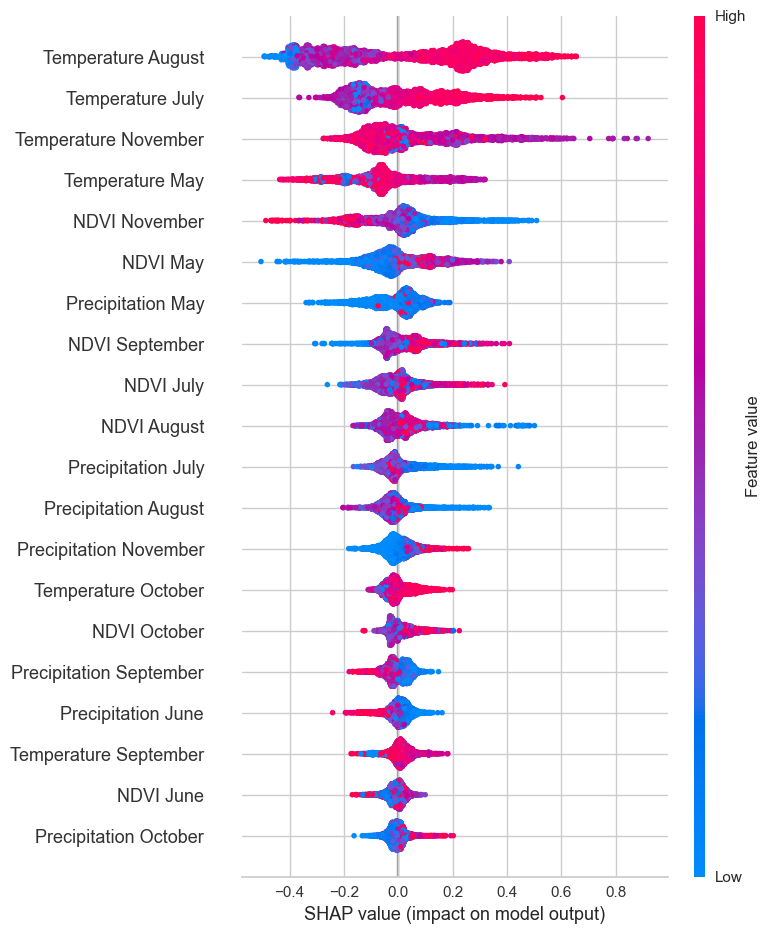

In [30]:
interpret_model(light_gbm_model, plot = 'summary', use_train_data=True)